In [1]:
%cd ..

/home/gianscarpe/dev/event-camera


In [4]:
from experimenting.dataset import DHP3DDataset, get_dataloader
from experimenting.dataset.indexes import get_dataset_params
from experimenting.utils import get_file_paths, decay_heatmap
from matplotlib import pyplot as plt
from os.path import join, basename
import numpy as np
from albumentations import Compose, CenterCrop
from albumentations.pytorch import ToTensor
import torch
from omegaconf import DictConfig
from experimenting.utils import get_file_paths, get_preload_dir, get_label_from_filename
import cv2

%matplotlib inline

## 

In [5]:
# Augmentation
aug = Compose([CenterCrop(256, 256), ToTensor()])

In [6]:
data_dir = '/data/dhp19/time_count_dataset/movements_per_frame'
labels_dir = '/data/dhp19/time_count_dataset/labels'

hparams = DictConfig({'path': data_dir, 'labels_dir' : labels_dir})
file_paths, train_index, val_index, test_index, _ = get_dataset_params(hparams)

LOADED INDEXES! train: 56137 	 val: 14035 	 test: 17543


In [7]:
d = DHP3DDataset(file_paths, labels_dir, test_index, transform=aug)
loader = get_dataloader(d, 32, 2)

In [8]:
def display(img):          
        fig, ax = plt.subplots(ncols=img.shape[0], nrows=1,                              
                               figsize=(20,20))                                                                                   
        for i in range(img.shape[0]):                                                                
            ax[i].imshow(img[i])                                                  
            ax[i].axis('off')
        plt.show()

In [9]:
batch = next(iter(loader))
x, y = batch

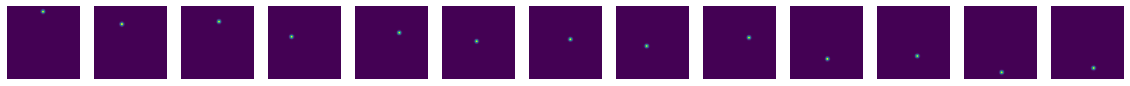

In [9]:
display(y[4].numpy())


## Try Loaded model for 2d heatmap prediction

In [2]:
import experimenting.models as models
from importlib import reload
import experimenting.utils as utils
reload(utils)
reload(models)
import pytorch_lightning as pl
import os
import experimenting.models.metrics as metrics
from importlib import reload
mp = metrics.MPJPE()

exp_name = 'exp_Adam_0.0003_center_crop_05-11-12-08_05-11-12-08'
checkpoint_dir = f'/home/gianscarpe/dev/exps/timecount_pose/exps_PoseEstimator/exps_unet_resnet18/{exp_name}/checkpoints'
checkpoints = sorted(os.listdir(checkpoint_dir))
checkpoint_path = os.path.join(checkpoint_dir, checkpoints[0])

In [3]:
model = models.PoseEstimator.load_from_checkpoint(checkpoint_path)
model = model.eval()
#model.model.segmentation_head[-1] = torch.nn.Identity()


NameError: name 'x' is not defined

In [277]:
gt_joints, _ = utils.get_heatmap_max(y)
p_joints, p_conf = utils.get_heatmap_max(preds)

In [288]:
mean_value = p_joints.mean(0).mean(0)
std_value = p_joints.std(0).std(0)

In [44]:
import experimenting.models.losses as losses
reload(losses)
l = losses.PixelWiseLoss()

In [25]:
preds = model.forward(x)

In [37]:
preds.size(-1)

256

In [40]:
losses._js(preds, y, 2).shape

torch.Size([32, 13])

In [45]:
l(preds, y)

> /home/gianscarpe/dev/event-camera/experimenting/models/dsnt.py(61)_coord_expectation()
-> expectations = summed.mul(own_coords.view(-1, own_coords.size(-1))).sum(-1)


(Pdb)  c


> /home/gianscarpe/dev/event-camera/experimenting/models/dsnt.py(61)_coord_expectation()
-> expectations = summed.mul(own_coords.view(-1, own_coords.size(-1))).sum(-1)


(Pdb)  c


> /home/gianscarpe/dev/event-camera/experimenting/models/dsnt.py(61)_coord_expectation()
-> expectations = summed.mul(own_coords.view(-1, own_coords.size(-1))).sum(-1)


(Pdb)  c


> /home/gianscarpe/dev/event-camera/experimenting/models/dsnt.py(61)_coord_expectation()
-> expectations = summed.mul(own_coords.view(-1, own_coords.size(-1))).sum(-1)


(Pdb)  c


tensor(46.1434, grad_fn=<DivBackward0>)

In [224]:
def plot_2d(dvs_frame, sample_gt, sample_pred):
    " To plot image and 2D ground truth and prediction "
    plt.figure()
    plt.imshow(dvs_frame, cmap='gray')
    plt.plot(sample_gt[:,1], sample_gt[:,0], '.', c='red', label='gt')
    plt.plot(sample_pred[:,1], sample_pred[:,0], '.', c='blue', label='pred')
    plt.legend()

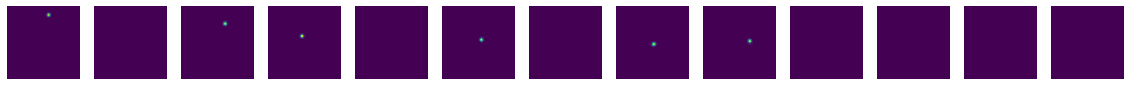

In [225]:
display(preds[0].numpy())

In [297]:
import experimenting.models.dsnt as dsnt

reload(dsnt)

<module 'experimenting.models.dsnt' from '/home/gianscarpe/dev/event-camera/experimenting/models/dsnt.py'>

In [246]:
p_joints[0]

tensor([[ 31, 146],
        [  0,   0],
        [ 61, 155],
        [105, 119],
        [  0,   0],
        [117, 138],
        [  0,   0],
        [134, 133],
        [123, 164],
        [  0,   0],
        [  0,   0],
        [  0,   0],
        [  0,   0]], dtype=torch.uint8)

In [304]:
def soft_arg_max(A, mask, beta=10, dim=1, epsilon=1e-12):
    '''
        applay softargmax on A and consider mask, return \sum_i ( i * (exp(A_i * beta) / \sum_i(exp(A_i * beta))))
        according to https://bouthilx.wordpress.com/2013/04/21/a-soft-argmax/
        :param A:
        :param mask:
        :param dim:
        :param epsilon:
        :return:
        '''
    # According to https://discuss.pytorch.org/t/apply-mask-softmax/14212/7
    A_max = torch.max(A, dim=dim, keepdim=True)[0]
    A_exp = torch.exp((A - A_max)*beta)
    #A_exp = A_exp * mask  # this step masks
    A_softmax = A_exp / (torch.sum(A_exp, dim=dim, keepdim=True) + epsilon)
    indices = torch.arange(start=0, end=A.size()[dim]).float()
    print(indices.size(), A_softmax.size())
    return torch.matmul(A_softmax, indices)

In [317]:
def _get_max_indices(x):
    """
        https://stackoverflow.com/questions/53212507/how-to-efficiently-retrieve-the-indices-of-maximum-values-in-a-torch-tensor
        """
    n = torch.tensor(x.shape[0])
    d = torch.tensor(x.shape[-1])
    m = x.view(n, -1).argmax(1)
    indices = torch.cat(((m / d).view(-1, 1), (m % d).view(-1, 1)), dim=1)
    return indices

In [321]:
ind = _get_max_indices(preds[0][0])
m, i = torch.max(preds[0][0])

TypeError: iteration over a 0-d tensor

In [19]:
import experimenting.models.soft_argmax as soft_argmax

In [ ]:
s = soft_argmax.SoftArgmax2D()
s(y.cuda())

In [302]:
t = lambda x: torch.zeros(256)
dsnt.dsnt(preds, transform=t)[0]

> /home/gianscarpe/dev/event-camera/experimenting/models/dsnt.py(61)_coord_expectation()
-> expectations = summed.mul(own_coords.view(-1, own_coords.size(-1))).sum(-1)


(Pdb)  c


> /home/gianscarpe/dev/event-camera/experimenting/models/dsnt.py(61)_coord_expectation()
-> expectations = summed.mul(own_coords.view(-1, own_coords.size(-1))).sum(-1)


(Pdb)  c


tensor([[ 91.8166,  91.8166],
        [  0.0000,   0.0000],
        [102.8264, 102.8264],
        [ 99.9655,  99.9654],
        [  0.0000,   0.0000],
        [ 97.7867,  97.7867],
        [  0.0000,   0.0000],
        [104.3473, 104.3473],
        [103.7785, 103.7785],
        [  0.0000,   0.0000],
        [  0.0000,   0.0000],
        [  0.0000,   0.0000],
        [  0.0000,   0.0000]], grad_fn=<SelectBackward>)

/home/gianscarpe/anaconda3/envs/event-camera/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


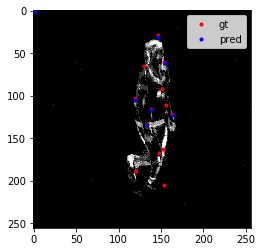

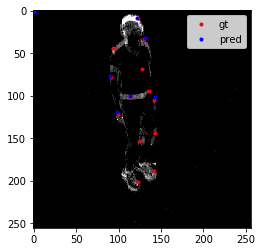

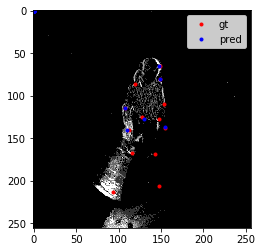

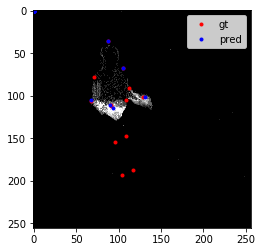

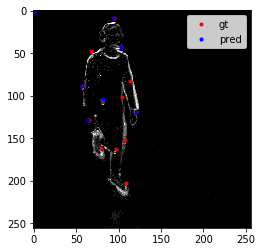

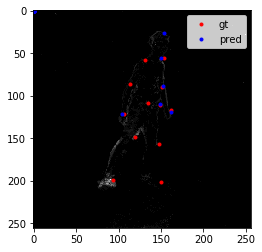

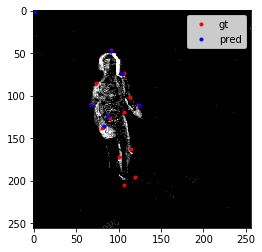

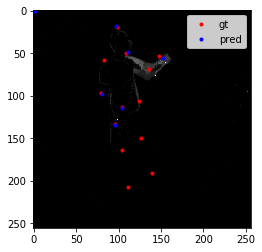

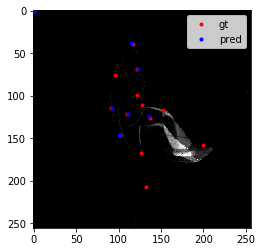

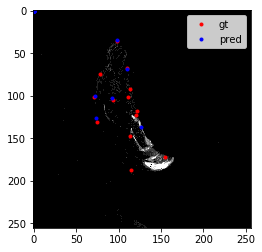

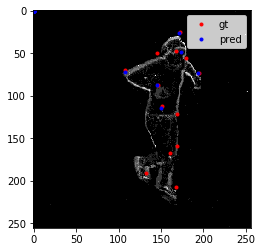

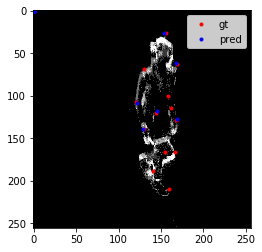

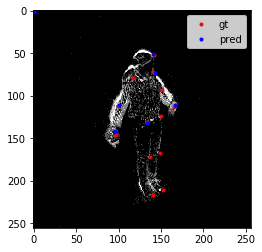

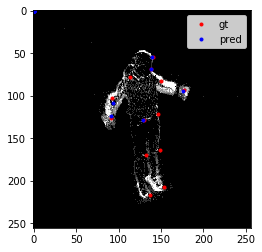

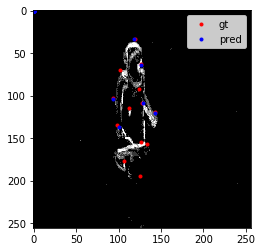

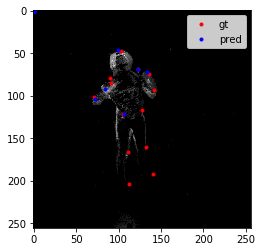

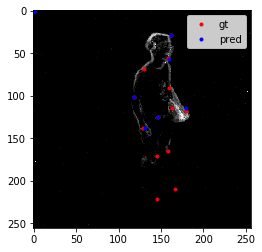

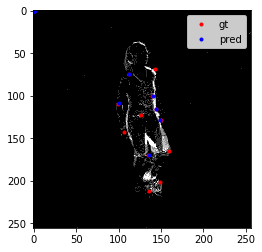

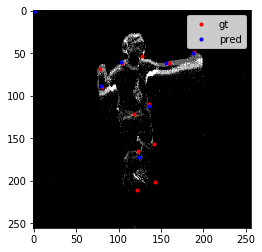

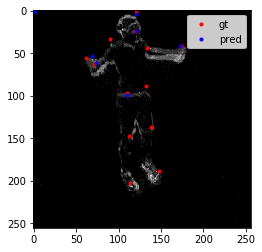

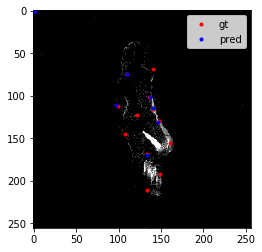

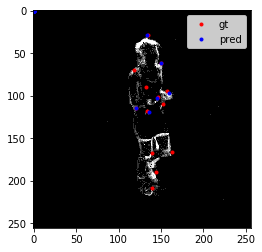

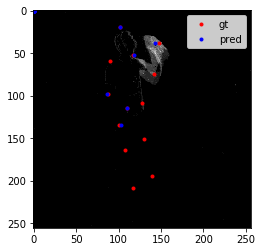

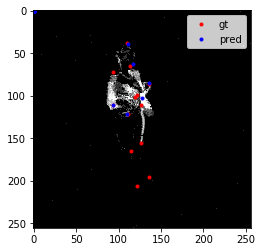

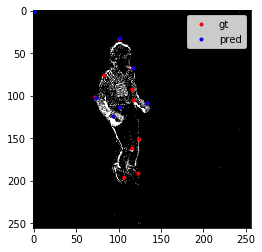

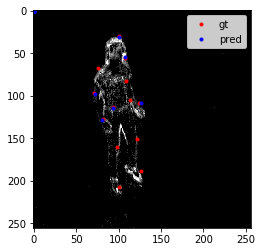

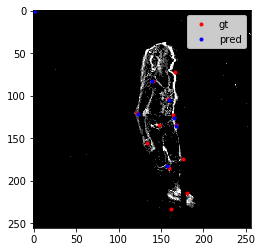

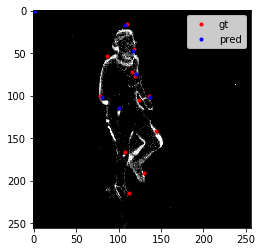

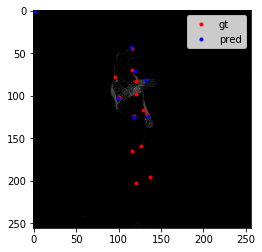

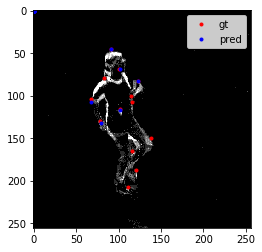

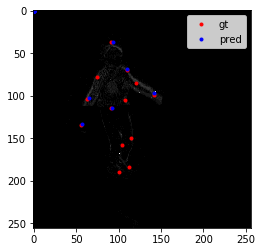

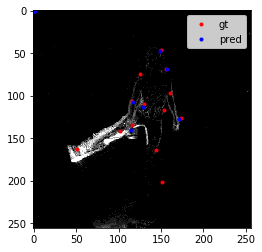

In [153]:
for i in range(0, 32):
    plot_2d(x[i].squeeze(), gt_joints[i], p_joints[i])

tensor(154.0929)